# Langzeit Scheduling

<b> Erkenntnisse: </b>
- Job-Reihenfolge im Solver ist relevant

In [1]:
import json
import random
import numpy as np
import pandas as pd

In [2]:
import pulp

In [3]:
import utils.checker as check
import utils.presenter as show
import utils.schedule_interarrival as sit
import utils.schedule_deadline as sdead
import utils.schedule_solver__with_arrivals as ssv

In [4]:
pd.set_option('display.max_rows', 30)

In [5]:
# Datei laden
with open("data/jobshop_instances.json", "r", encoding="utf-8") as f:
    jobshop_instances = json.load(f)

instance =  jobshop_instances["instance ft10"]
show.print_jobs(instance)

job 0:  [[0, 29], [1, 78], [2, 9], [3, 36], [4, 49], [5, 11], [6, 62], [7, 56], [8, 44], [9, 21]]
job 1:  [[0, 43], [2, 90], [4, 75], [9, 11], [3, 69], [1, 28], [6, 46], [5, 46], [7, 72], [8, 30]]
job 2:  [[1, 91], [0, 85], [3, 39], [2, 74], [8, 90], [5, 10], [7, 12], [6, 89], [9, 45], [4, 33]]
job 3:  [[1, 81], [2, 95], [0, 71], [4, 99], [6, 9], [8, 52], [7, 85], [3, 98], [9, 22], [5, 43]]
job 4:  [[2, 14], [0, 6], [1, 22], [5, 61], [3, 26], [4, 69], [8, 21], [7, 49], [9, 72], [6, 53]]
job 5:  [[2, 84], [1, 2], [5, 52], [3, 95], [8, 48], [9, 72], [0, 47], [6, 65], [4, 6], [7, 25]]
job 6:  [[1, 46], [0, 37], [3, 61], [2, 13], [6, 32], [5, 21], [9, 32], [8, 89], [7, 30], [4, 55]]
job 7:  [[2, 31], [0, 86], [1, 46], [5, 74], [4, 32], [6, 88], [8, 19], [9, 48], [7, 36], [3, 79]]
job 8:  [[0, 76], [1, 69], [3, 76], [5, 51], [2, 85], [9, 11], [6, 40], [7, 89], [4, 26], [8, 74]]
job 9:  [[1, 85], [0, 13], [2, 61], [6, 7], [8, 64], [9, 76], [5, 47], [3, 52], [4, 90], [7, 45]]



In [7]:
def add_jobs_to_dict(job_set_dict, new_instance, shuffle=False, seed=50):
    offset = len(job_set_dict)
    items = list(new_instance.items())

    if shuffle:
        random.seed(seed)
        random.shuffle(items)

    for i, (_, ops) in enumerate(items):
        job_name = f"Job_{offset + i:03d}"
        job_set_dict[job_name] = ops

In [9]:
def generate_jobs_for_days(day_numb: int, jobs_instance: dict):
    jssp_data = {}

    # Schritt 1: Ursprüngliche Instanz vervielfachen (geschätzt mit Puffer)
    for i in range(int(2.3 *day_numb)):
        shuffle = False if (i % 2 == 0) else True
        add_jobs_to_dict(jssp_data, jobs_instance, shuffle)

    # Schritt 2: Zwischenankunftszeiten berechnen
    mean_interarrival_time = sit.calculate_mean_interarrival_time(jssp_data)
    df_arrivals = sit.generate_job_arrivals_df_by_mean_interarrival_time(jssp_data, t_a=mean_interarrival_time)

    
    # Schritt 3a: Filter auf df_arrivals anwenden
    df_arrivals = df_arrivals[df_arrivals["Arrival"] <= (60 * 24 * day_numb)]
    df_arrivals

    # Schritt 3b: Nur die verbleibenden Job-IDs extrahieren
    valid_job_ids = set(df_arrivals["Job"])

    # Schritt 3c: jssp_data kürzen
    jssp_data = {job_id: ops for job_id, ops in jssp_data.items() if job_id in valid_job_ids}

    return jssp_data, df_arrivals


In [10]:
jssp_data, df_arrivals = generate_jobs_for_days(2, instance)
show.print_jobs(jssp_data)

Job_000:  [[0, 29], [1, 78], [2, 9], [3, 36], [4, 49], [5, 11], [6, 62], [7, 56], [8, 44], [9, 21]]
Job_001:  [[0, 43], [2, 90], [4, 75], [9, 11], [3, 69], [1, 28], [6, 46], [5, 46], [7, 72], [8, 30]]
Job_002:  [[1, 91], [0, 85], [3, 39], [2, 74], [8, 90], [5, 10], [7, 12], [6, 89], [9, 45], [4, 33]]
Job_003:  [[1, 81], [2, 95], [0, 71], [4, 99], [6, 9], [8, 52], [7, 85], [3, 98], [9, 22], [5, 43]]
Job_004:  [[2, 14], [0, 6], [1, 22], [5, 61], [3, 26], [4, 69], [8, 21], [7, 49], [9, 72], [6, 53]]
Job_005:  [[2, 84], [1, 2], [5, 52], [3, 95], [8, 48], [9, 72], [0, 47], [6, 65], [4, 6], [7, 25]]
Job_006:  [[1, 46], [0, 37], [3, 61], [2, 13], [6, 32], [5, 21], [9, 32], [8, 89], [7, 30], [4, 55]]
Job_007:  [[2, 31], [0, 86], [1, 46], [5, 74], [4, 32], [6, 88], [8, 19], [9, 48], [7, 36], [3, 79]]
Job_008:  [[0, 76], [1, 69], [3, 76], [5, 51], [2, 85], [9, 11], [6, 40], [7, 89], [4, 26], [8, 74]]
Job_009:  [[1, 85], [0, 13], [2, 61], [6, 7], [8, 64], [9, 76], [5, 47], [3, 52], [4, 90], [7, 4

In [11]:
df_arrivals

,Job,Arrival
0,Job_000,0.00
1,Job_001,84.93
2,Job_002,106.18
3,Job_003,148.31
4,Job_004,185.08
...,...,...
35,Job_035,1901.00
36,Job_036,2252.10
37,Job_037,2255.70
38,Job_038,2263.80


In [12]:
# Puffer 1.5 => Deadline = Arrival + k* Bearbeitungszeit * (1 + 3,0)  (300% Extra Bearbeitungszeit im Schnitt)
k_opt, deadlines = sdead.find_k(jssp_data, df_arrivals, ssv.schedule_fcfs_with_arrivals, target_service=1, final_buffer = 3.0)
print(f"Gefundener Due-Date-Faktor k = {k_opt:.4f}")

Gefundener Due-Date-Faktor k = 3.3293


In [21]:
df_arrivals_deadlines = df_arrivals.assign(Deadline=df_arrivals["Job"].map(deadlines)).sort_values("Arrival")
df_arrivals_deadlines

,Job,Arrival,Deadline
0,Job_000,0.00,2500.080817
1,Job_001,84.93,3312.882447
2,Job_002,106.18,3701.232921
3,Job_003,148.31,4294.013633
4,Job_004,185.08,2672.502180
...,...,...,...
35,Job_035,1901.00,5128.952447
36,Job_036,2252.10,5669.932003
37,Job_037,2255.70,5395.041988
38,Job_038,2263.80,4751.222180


In [40]:
import numpy as np

def count_column_grouped(df, column='Tardiness', bins=[-np.inf, 0, 200, 500, np.inf], labels=['<0', '0-200', '200-500', '>500'],right=False):

    # Input-Validierung
    if column not in df.columns:
        raise ValueError(f"Spalte '{column}' nicht im DataFrame gefunden")
    
    if len(bins) != len(labels) + 1:
        raise ValueError("Anzahl bins muss Anzahl labels + 1 sein")
    
    # Gruppierung durchführen
    grouped = pd.cut(df[column], bins=bins, labels=labels, right=right, include_lowest=True)
    
    # Ergebnis mit garantierter Reihenfolge
    return grouped.value_counts().reindex(labels, fill_value=0)


In [75]:

import pandas as pd
import numpy as np

def count_column_grouped(df, column='Tardiness', bins=[-np.inf, 0, 100, 200, 500, 1000, np.inf], right_closed=False):
    """
    Zählt Werte in Gruppen mit automatischer Label-Generierung.
    
    Parameters:
        df (pd.DataFrame): Input DataFrame
        column (str): Zu gruppierende Spalte
        bins (list): Intervallgrenzen
        right_closed (bool): Rechte Grenze inklusive?
    
    Returns:
        pd.Series: Gezählte Werte mit automatischen Labels
    """
    # Input-Validierung
    if column not in df.columns:
        available_cols = ', '.join(df.columns)
        raise ValueError(f"Spalte '{column}' nicht vorhanden. Verfügbar: {available_cols}")
    
    # Automatische Label-Generierung
    labels = []
    for i in range(len(bins)-1):
        left = bins[i]
        right = bins[i+1]
        
        if left == -np.inf:
            labels.append(f"<{right}")
        elif right == np.inf:
            labels.append(f">{left}")
        elif left == 0:
            labels.append("0")
        else:
            labels.append(f"{left}-{right}")
    
    # Sonderbehandlung für exakte Nullwerte
    zero_mask = df[column] == 0
    zero_count = zero_mask.sum()
    
    # Gruppierung der Nicht-Null-Werte
    non_zero = df[~zero_mask][column]
    grouped = pd.cut(non_zero,
                   bins=bins,
                   labels=labels[1:],  # Überspringt das <0 Label für Nicht-Null-Werte
                   right=right_closed)
    
    # Kombination der Ergebnisse
    result = pd.Series([zero_count], index=['0']).append(
        grouped.value_counts()
    ).reindex(labels, fill_value=0).astype(int)
    
    return result

In [81]:
import pandas as pd
import numpy as np

def count_column_grouped(
    df,
    column='Tardiness',
    bins=[-np.inf, 0, 100, 200, 500, 1000, 2000, np.inf],
    right_closed=False
):
    """
    Zählt Werte in intuitiv gruppierten Intervallen (inkl. spezieller 0-Kategorie).
    
    Parameters:
        df (pd.DataFrame): Input DataFrame
        column (str): Zu gruppierende Spalte
        bins (list): Intervallgrenzen (Standard: [-∞,0,100,200,500,∞])
        right_closed (bool): Rechte Grenze inklusive? (Standard: False)
    
    Returns:
        pd.Series: Gezählte Werte pro Gruppe, sortiert nach Intervallen
    """
    # 1. Input-Validierung
    if column not in df.columns:
        raise ValueError(f"Spalte '{column}' existiert nicht. Verfügbare Spalten: {list(df.columns)}")
    
    # 2. Automatische Label-Erstellung
    labels = []
    for i in range(len(bins)-1):
        left, right = bins[i], bins[i+1]
        
        if left == -np.inf:
            labels.append(f"<{right}")
        elif right == np.inf:
            labels.append(f">{left}")
        elif left == 0:
            labels.append("0")
        else:
            labels.append(f"{int(left)}-{int(right)}" if left.is_integer() and right.is_integer() else f"{left}-{right}")
    
    # 3. Gruppierung
    result = (
        pd.cut(df[column], 
              bins=bins,
              labels=labels,
              right=right_closed)
        .value_counts()
        .reindex(labels, fill_value=0)
        .astype(int)
    )
    
    return result

## 0) FCFS

In [24]:
df_plan_fcfs = ssv.schedule_fcfs_with_arrivals(jssp_data, df_arrivals)
df_plan_fcfs

,Job,Arrival,Machine,Start,Processing Time,End
0,Job_000,0.00,M0,0.00,29,29.00
1,Job_000,0.00,M1,29.00,78,107.00
3,Job_000,0.00,M2,107.00,9,116.00
5,Job_000,0.00,M3,116.00,36,152.00
7,Job_000,0.00,M4,152.00,49,201.00
...,...,...,...,...,...,...
380,Job_039,2264.94,M6,2989.44,88,3077.44
386,Job_039,2264.94,M8,3077.44,19,3096.44
393,Job_039,2264.94,M9,3191.44,48,3239.44
398,Job_039,2264.94,M7,3284.44,36,3320.44


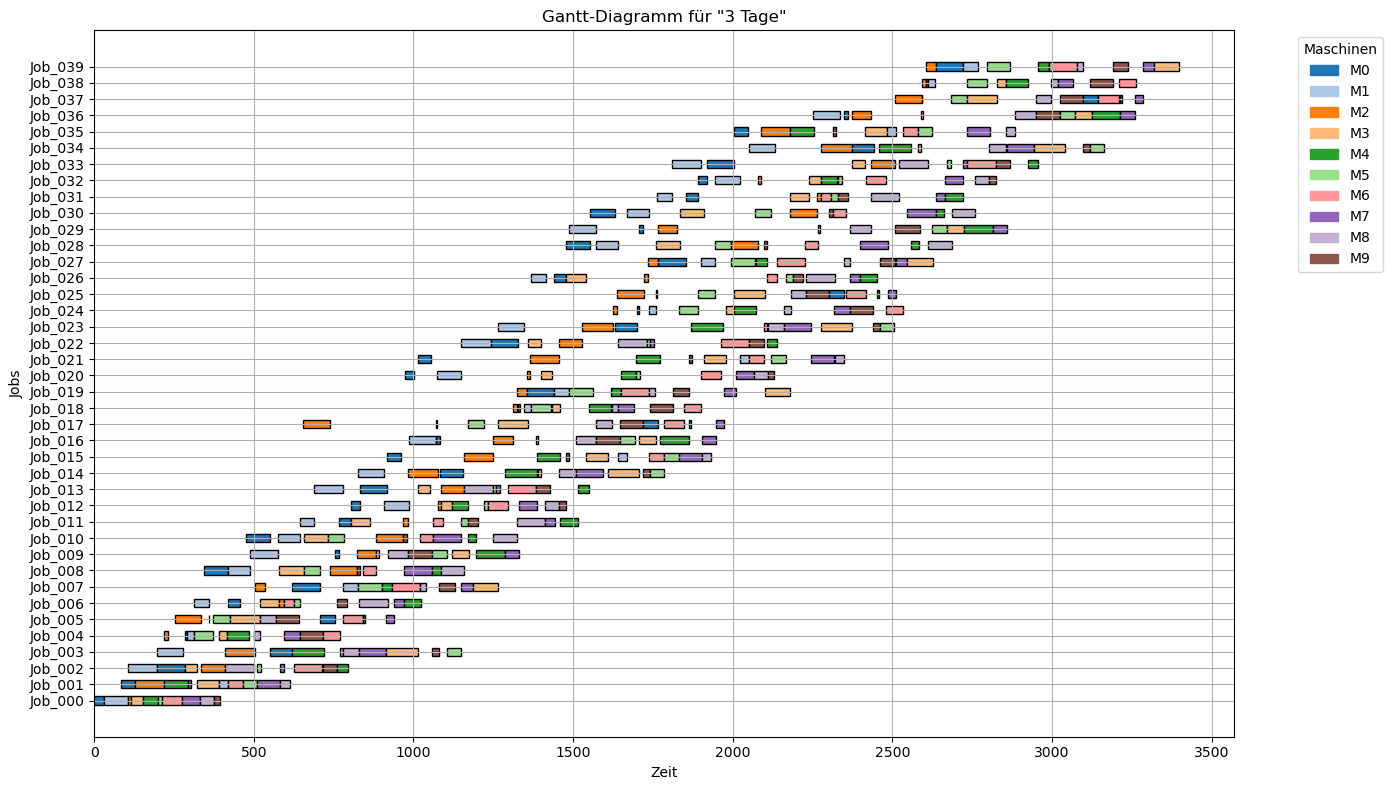

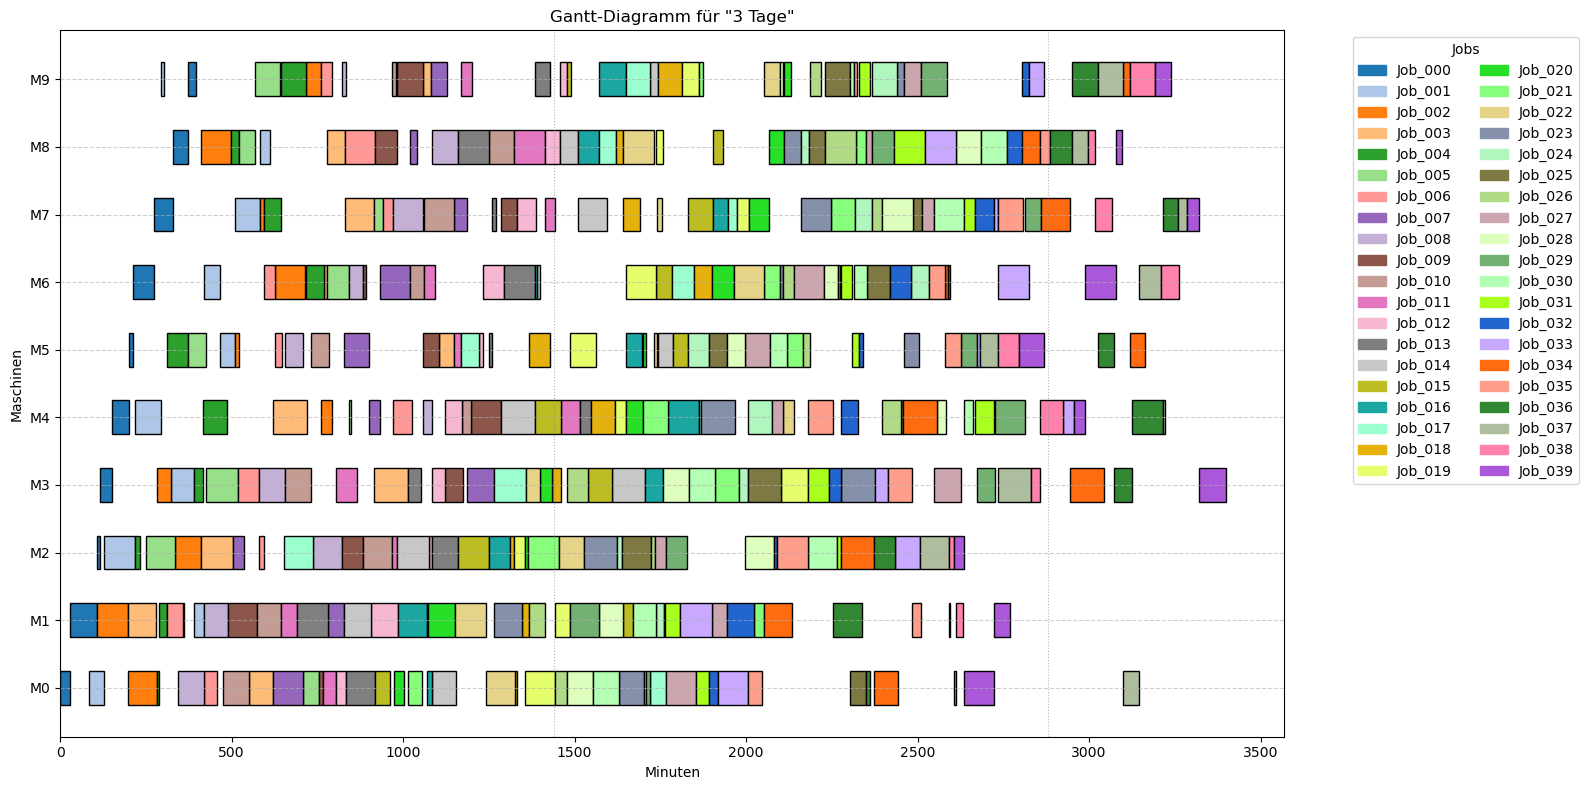

✅ Keine Maschinenkonflikte gefunden
✅ Job-Machinen-Reihenfolge (Reihenfolge der Operationen je Job) ist korrekt!
✅ Alle Operation starten erst nach Arrival des Job
✅ Zeitliche technologische Reihenfolge korrekt.

✅ Alle Constraints wurden erfüllt.



True

In [26]:
df = df_plan_fcfs
category = "3 Tage"
show.plot_gantt_jobs(df, 'Gantt-Diagramm für "{}"'.format(category), duration_column = "Processing Time")
show.plot_gantt_machines(df, 'Gantt-Diagramm für "{}"'.format(category), duration_column = "Processing Time")

check.check_all_constraints(df, jssp_data)

## Tardiness
- Tardiness = 0, wenn der Auftrag rechtzeitig oder sogar vorzeitig fertiggestellt wurde.
- Tardiness > 0, wenn der Auftrag später fertiggestellt wird als ursprünglich vorgesehen
- berücksichtigt nur positive Abweichungen, also nur tatsächliche Verspätungen.

$$
T_j = \max(0,\; C_j - d_j)
$$

**Legende:**

- $T_j$: Tardiness (Verspätung) des Jobs $j$  
- $C_j$: tatsächliche Fertigstellungszeit (Completion Time) von Job $j$  
- $d_j$: Deadline bzw. geplanter Fertigstellungstermin von Job $j$

**Interpretation:**

- $T_j > 0$: Job ist **verspätet**  
- $T_j = 0$: Job ist **pünktlich oder zu früh**  
- Frühfertigungen werden **nicht bestraft**, sondern zu $0$ gesetzt


### a) Summe der Tardiness' minimieren

$$
\min \; \sum_{j \in J} \max(0,\; C_j - d_j)
$$

**Legende:**

- $J$: Menge aller Jobs  
- $C_j$: tatsächliche Fertigstellungszeit (Completion Time) von Job $j$  
- $d_j$: Deadline von Job $j$  
- $\max(0,\; C_j - d_j)$: Tardiness von Job $j$  
- Die Summe betrachtet **nur verspätete Jobs** – Frühfertigungen zählen nicht.

**Erklärung:**  
Diese Zielfunktion minimiert die **Gesamtheit aller Verspätungen**, d. h. die Summe aller positiven Abweichungen von den Deadlines.


In [45]:
def solve_jssp_sum_tardiness(job_dict, df_arrivals_deadlines, solver_time_limit=1200, epsilon=0.00):
    """
    Minimiert die Summe der Tardiness (Verspätungen) aller Jobs.
    Zielfunktion: sum_j [ max(0, Endzeit_j - Deadline_j) ]

    Parameter:
    - job_dict: Dictionary mit Jobdaten (jede Operation als (Maschine, Dauer))
    - df_arrivals_deadlines: DataFrame mit Spalten "Job", "Arrival", "Deadline"
    - solver_time_limit: Max. Zeit in Sekunden für den Solver
    - epsilon: Kleiner Abstand zur Vermeidung von Maschinenkonflikten
    """

    import pulp
    import pandas as pd

    # Daten vorbereiten
    df_arrivals_deadlines = df_arrivals_deadlines.sort_values("Arrival").reset_index(drop=True)
    arrival_times = df_arrivals_deadlines.set_index("Job")["Arrival"].to_dict()
    deadlines = df_arrivals_deadlines.set_index("Job")["Deadline"].to_dict()

    job_names = list(df_arrivals_deadlines.sort_values("Arrival", ascending=False)["Job"])

    num_jobs = len(job_names)
    all_ops = [job_dict[job] for job in job_names]
    all_machines = {op[0] for job in all_ops for op in job}

    # LP-Problem definieren
    prob = pulp.LpProblem("JobShop_Total_Tardiness", pulp.LpMinimize)

    # Variablen
    starts = {
        (j, o): pulp.LpVariable(f"start_{j}_{o}", lowBound=0, cat="Continuous")
        for j in range(num_jobs) for o in range(len(all_ops[j]))
    }

    job_ends = {
        j: pulp.LpVariable(f"job_end_{j}", lowBound=0, cat="Continuous")
        for j in range(num_jobs)
    }

    tardiness = {
        j: pulp.LpVariable(f"tardiness_{j}", lowBound=0, cat="Continuous")
        for j in range(num_jobs)
    }

    # Zielfunktion: Summe der Tardiness
    prob += pulp.lpSum([tardiness[j] for j in range(num_jobs)])

    # Technologische Reihenfolge & Ankunftszeit
    for j, job_name in enumerate(job_names):
        job = job_dict[job_name]
        prob += starts[(j, 0)] >= arrival_times[job_name]
        for o in range(1, len(job)):
            d_prev = job[o - 1][1]
            prob += starts[(j, o)] >= starts[(j, o - 1)] + d_prev

    # Maschinenkonflikte (Disjunktivität)
    bigM = 1e5
    for m in all_machines:
        ops = [(j, o, d) for j in range(num_jobs)
               for o, (mach, d) in enumerate(all_ops[j]) if mach == m]
        for i in range(len(ops)):
            j1, o1, d1 = ops[i]
            for j2, o2, d2 in ops[i + 1:]:
                if j1 != j2:
                    y = pulp.LpVariable(f"y_{j1}_{o1}_{j2}_{o2}", cat="Binary")
                    prob += starts[(j1, o1)] + d1 + epsilon <= starts[(j2, o2)] + bigM * (1 - y)
                    prob += starts[(j2, o2)] + d2 + epsilon <= starts[(j1, o1)] + bigM * y

    # Job-Endzeiten und Tardiness
    for j, job_name in enumerate(job_names):
        last_op = len(all_ops[j]) - 1
    
        # Endzeit = Ende der letzten Operation (genau, nicht nur >=)
        prob += job_ends[j] == starts[(j, last_op)] + all_ops[j][last_op][1]  #prob += job_ends[j] >= starts[(j, last_op)] + all_ops[j][last_op][1]
    
        # Tardiness-Definition
        prob += tardiness[j] >= job_ends[j] - deadlines[job_name]


    # Solver starten
    solver = pulp.HiGHS_CMD(msg=True, timeLimit=solver_time_limit)
    prob.solve(solver)

    # Zeitplan extrahieren
    schedule_data = []
    for (j, o), var in sorted(starts.items()):
        start = var.varValue
        if start is not None:
            machine, duration = all_ops[j][o]
            end = start + duration
            schedule_data.append({
                "Job": job_names[j],
                "Machine": f"M{machine}",
                "Start": round(start, 2),
                "Processing Time": duration,
                "End": round(end, 2)
            })

    df_schedule = pd.DataFrame(schedule_data)
    df_schedule["Arrival"] = df_schedule["Job"].map(arrival_times)
    df_schedule["Deadline"] = df_schedule["Job"].map(deadlines)
    df_schedule["Tardiness"] = df_schedule.groupby("Job")["End"].transform("max") - df_schedule["Deadline"]
    df_schedule["Tardiness"] = df_schedule["Tardiness"].clip(lower=0)

    df_schedule = df_schedule[["Job", "Arrival", "Deadline", "Machine", "Start", "Processing Time", "End", "Tardiness"]]

    total_tardiness = round(pulp.value(prob.objective), 3)
    print(f"Total Tardiness: {total_tardiness}")

    return df_schedule


In [47]:
df_plan_sum_tardiness = solve_jssp_sum_tardiness(jssp_data, df_arrivals_deadlines, solver_time_limit=2700, epsilon=0.00)
df_plan_sum_tardiness

Total Tardiness: 89919.435


,Job,Arrival,Deadline,Machine,Start,Processing Time,End,Tardiness
0,Job_039,2264.94,5676.442684,M2,10607.93,31,10638.93,5990.487316
1,Job_039,2264.94,5676.442684,M0,11023.93,86,11109.93,5990.487316
2,Job_039,2264.94,5676.442684,M1,11109.93,46,11155.93,5990.487316
3,Job_039,2264.94,5676.442684,M5,11155.93,74,11229.93,5990.487316
4,Job_039,2264.94,5676.442684,M4,11229.93,32,11261.93,5990.487316
...,...,...,...,...,...,...,...,...
395,Job_000,0.00,2500.080817,M5,201.00,11,212.00,0.000000
396,Job_000,0.00,2500.080817,M6,212.00,62,274.00,0.000000
397,Job_000,0.00,2500.080817,M7,274.00,56,330.00,0.000000
398,Job_000,0.00,2500.080817,M8,330.00,44,374.00,0.000000


In [83]:
count_column_grouped(df_plan_sum_tardiness, 'Tardiness')

Tardiness
<0             0
0            130
100-200        0
200-500       10
500-1000      20
1000-2000     60
>2000        180
Name: count, dtype: int32

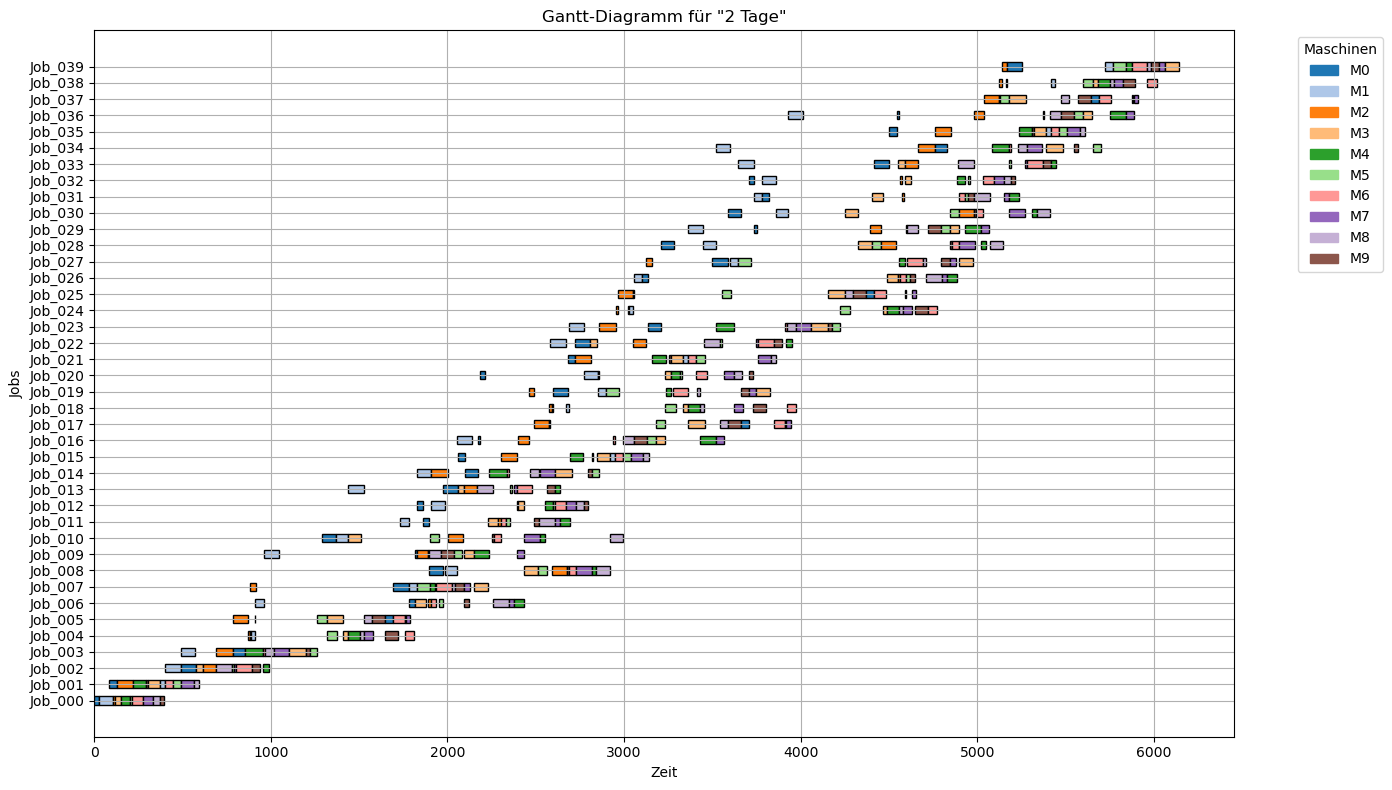

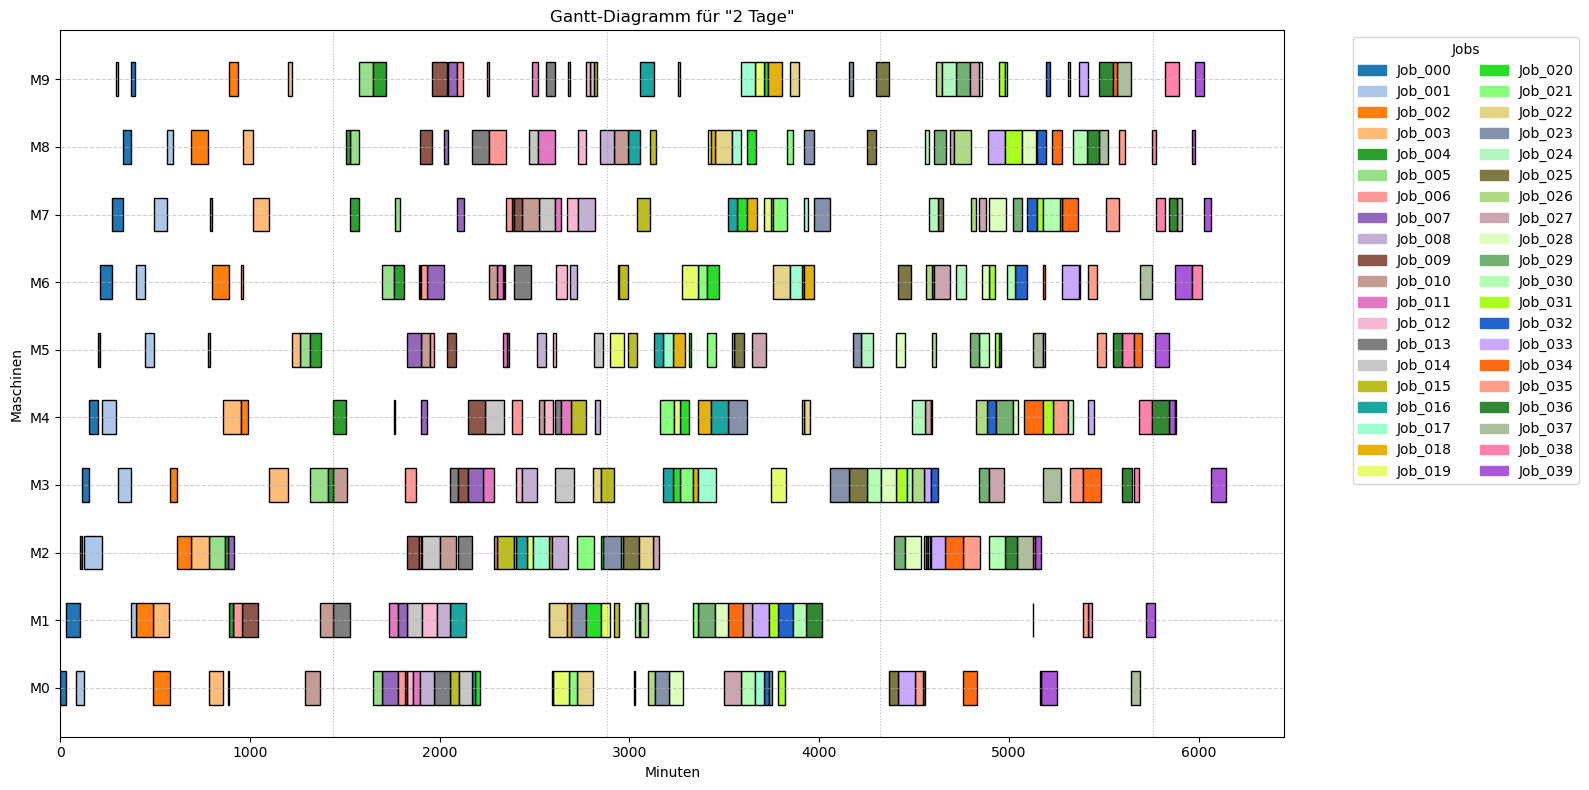

✅ Keine Maschinenkonflikte gefunden
✅ Job-Machinen-Reihenfolge (Reihenfolge der Operationen je Job) ist korrekt!
✅ Alle Operation starten erst nach Arrival des Job
✅ Zeitliche technologische Reihenfolge korrekt.

✅ Alle Constraints wurden erfüllt.



True

In [24]:
df = df_plan_sum_tardiness
category = "2 Tage"
show.plot_gantt_jobs(df, 'Gantt-Diagramm für "{}"'.format(category), duration_column = "Processing Time")
show.plot_gantt_machines(df, 'Gantt-Diagramm für "{}"'.format(category), duration_column = "Processing Time")

check.check_all_constraints(df, jssp_data)

### b)

$$
\min \; \max_{j \in J} \left( \max(0,\; C_j - d_j) \right)
$$

**Legende:**

- $J$: Menge aller Jobs  
- $C_j$: tatsächliche Fertigstellungszeit (Completion Time) von Job $j$  
- $d_j$: Deadline von Job $j$  
- $\max(0,\; C_j - d_j)$: Tardiness des Jobs $j$  
- Die äußere $\max$-Funktion bestimmt den Job mit der **größten Verspätung**

**Erklärung:**  
Diese Zielfunktion minimiert die **schlimmste Deadline-Überschreitung** unter allen Jobs. Frühfertigungen fließen dabei **nicht** ein.


In [26]:
def solve_jssp_max_tardiness(job_dict, df_arrivals_deadlines, solver_time_limit=1200, epsilon=0.00):
    """
    Minimiert die maximale Tardiness (Verspätung) unter allen Jobs.
    Zielfunktion: max_j [ max(0, Endzeit_j - Deadline_j) ]

    Parameter:
    - job_dict: Dictionary mit Jobdaten (jede Operation als (Maschine, Dauer))
    - df_arrivals_deadlines: DataFrame mit Spalten "Job", "Arrival", "Deadline"
    - solver_time_limit: Max. Zeit in Sekunden für den Solver
    - epsilon: Kleiner Abstand zur Vermeidung von Maschinenkonflikten
    """

    # Daten vorbereiten
    df_arrivals_deadlines = df_arrivals_deadlines.sort_values("Arrival").reset_index(drop=True)
    arrival_times = df_arrivals_deadlines.set_index("Job")["Arrival"].to_dict()
    deadlines = df_arrivals_deadlines.set_index("Job")["Deadline"].to_dict()

    job_names = list(df_arrivals_deadlines.sort_values("Arrival", ascending=False)["Job"])

    num_jobs = len(job_names)
    all_ops = [job_dict[job] for job in job_names]
    all_machines = {op[0] for job in all_ops for op in job}

    # LP-Problem definieren
    prob = pulp.LpProblem("JobShop_Max_Tardiness", pulp.LpMinimize)

    # Variablen
    starts = {
        (j, o): pulp.LpVariable(f"start_{j}_{o}", lowBound=0, cat="Continuous")
        for j in range(num_jobs) for o in range(len(all_ops[j]))
    }

    job_ends = {
        j: pulp.LpVariable(f"job_end_{j}", lowBound=0, cat="Continuous")
        for j in range(num_jobs)
    }

    tardiness = {
        j: pulp.LpVariable(f"tardiness_{j}", lowBound=0, cat="Continuous")
        for j in range(num_jobs)
    }

    max_tardiness = pulp.LpVariable("max_tardiness", lowBound=0, cat="Continuous")

    # Zielfunktion: maximale Tardiness minimieren
    prob += max_tardiness

    # Technologische Reihenfolge & Ankunftszeit
    for j, job_name in enumerate(job_names):
        job = job_dict[job_name]
        prob += starts[(j, 0)] >= arrival_times[job_name]
        for o in range(1, len(job)):
            d_prev = job[o - 1][1]
            prob += starts[(j, o)] >= starts[(j, o - 1)] + d_prev

    # Maschinenkonflikte (Disjunktivität)
    bigM = 1e5
    for m in all_machines:
        ops = [(j, o, d) for j in range(num_jobs)
               for o, (mach, d) in enumerate(all_ops[j]) if mach == m]
        for i in range(len(ops)):
            j1, o1, d1 = ops[i]
            for j2, o2, d2 in ops[i + 1:]:
                if j1 != j2:
                    y = pulp.LpVariable(f"y_{j1}_{o1}_{j2}_{o2}", cat="Binary")
                    prob += starts[(j1, o1)] + d1 + epsilon <= starts[(j2, o2)] + bigM * (1 - y)
                    prob += starts[(j2, o2)] + d2 + epsilon <= starts[(j1, o1)] + bigM * y

    # Endzeit = Ende letzter Operation; Tardiness-Definition
    for j, job_name in enumerate(job_names):
        last_op = len(all_ops[j]) - 1
        prob += job_ends[j] == starts[(j, last_op)] + all_ops[j][last_op][1]
        prob += tardiness[j] >= job_ends[j] - deadlines[job_name]
        prob += max_tardiness >= tardiness[j]

    # Solver starten
    solver = pulp.HiGHS_CMD(msg=True, timeLimit=solver_time_limit)
    prob.solve(solver)

    # Zeitplan extrahieren
    schedule_data = []
    for (j, o), var in sorted(starts.items()):
        start = var.varValue
        if start is not None:
            machine, duration = all_ops[j][o]
            end = start + duration
            schedule_data.append({
                "Job": job_names[j],
                "Machine": f"M{machine}",
                "Start": round(start, 2),
                "Processing Time": duration,
                "End": round(end, 2)
            })

    df_schedule = pd.DataFrame(schedule_data)
    df_schedule["Arrival"] = df_schedule["Job"].map(arrival_times)
    df_schedule["Deadline"] = df_schedule["Job"].map(deadlines)
    df_schedule["Tardiness"] = df_schedule.groupby("Job")["End"].transform("max") - df_schedule["Deadline"]
    df_schedule["Tardiness"] = df_schedule["Tardiness"].clip(lower=0)

    df_schedule = df_schedule[["Job", "Arrival", "Deadline", "Machine", "Start", "Processing Time", "End", "Tardiness"]]

    print("Maximale Tardiness:", round(pulp.value(max_tardiness), 3))
    return df_schedule


In [28]:
df_plan_max_tardiness = solve_jssp_max_tardiness(jssp_data, df_arrivals_deadlines, solver_time_limit=2700, epsilon=0.00)
df_plan_max_tardiness

Maximale Tardiness: 995.708


,Job,Arrival,Deadline,Machine,Start,Processing Time,End,Tardiness
0,Job_039,2264.94,5676.442684,M2,5001.93,31,5032.93,340.487316
1,Job_039,2264.94,5676.442684,M0,5411.93,86,5497.93,340.487316
2,Job_039,2264.94,5676.442684,M1,5497.93,46,5543.93,340.487316
3,Job_039,2264.94,5676.442684,M5,5543.93,74,5617.93,340.487316
4,Job_039,2264.94,5676.442684,M4,5617.93,32,5649.93,340.487316
...,...,...,...,...,...,...,...,...
395,Job_000,0.00,2500.080817,M5,201.00,11,212.00,0.000000
396,Job_000,0.00,2500.080817,M6,212.00,62,274.00,0.000000
397,Job_000,0.00,2500.080817,M7,274.00,56,330.00,0.000000
398,Job_000,0.00,2500.080817,M8,330.00,44,374.00,0.000000


In [55]:
count_column_grouped(df_plan_max_tardiness, 'Tardiness')

NameError: name 'df_plan_max_tardiness' is not defined

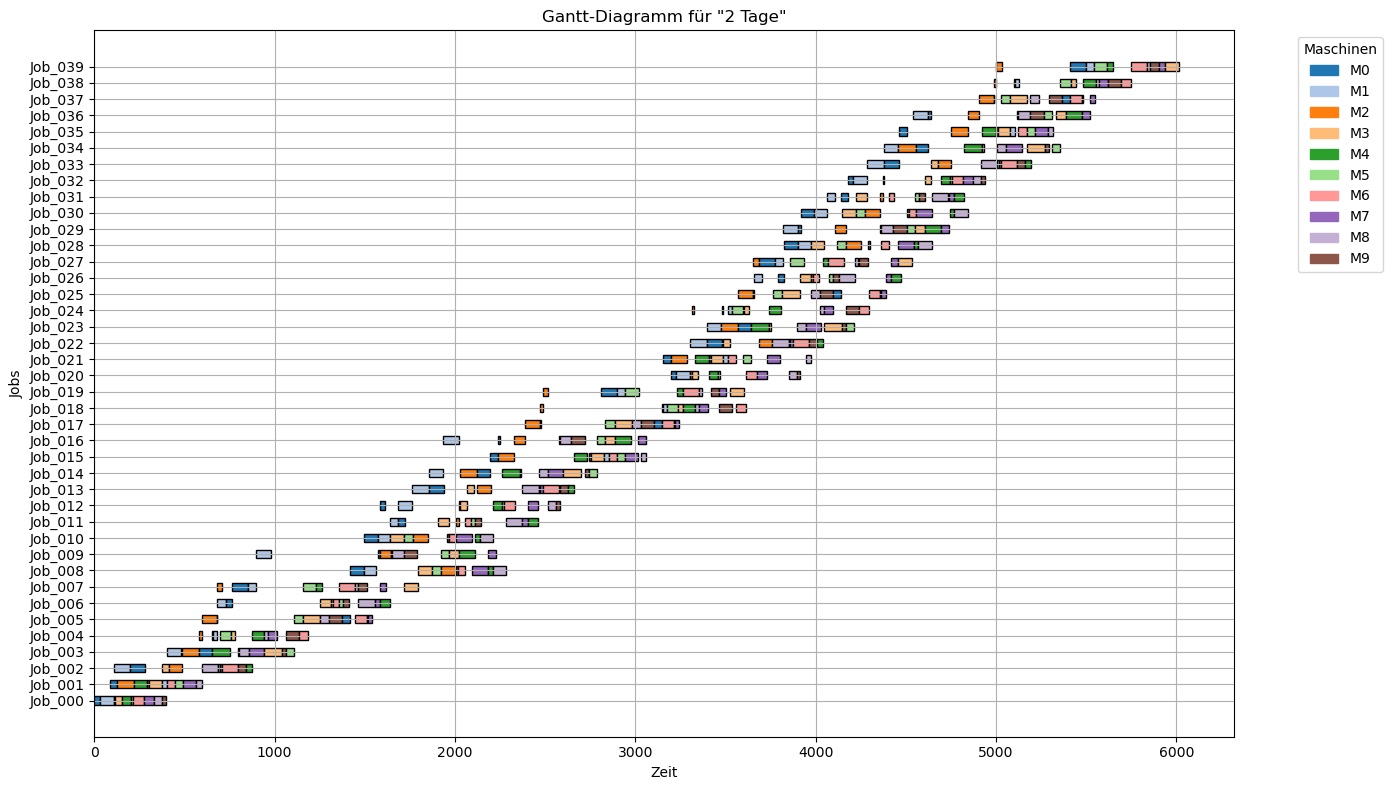

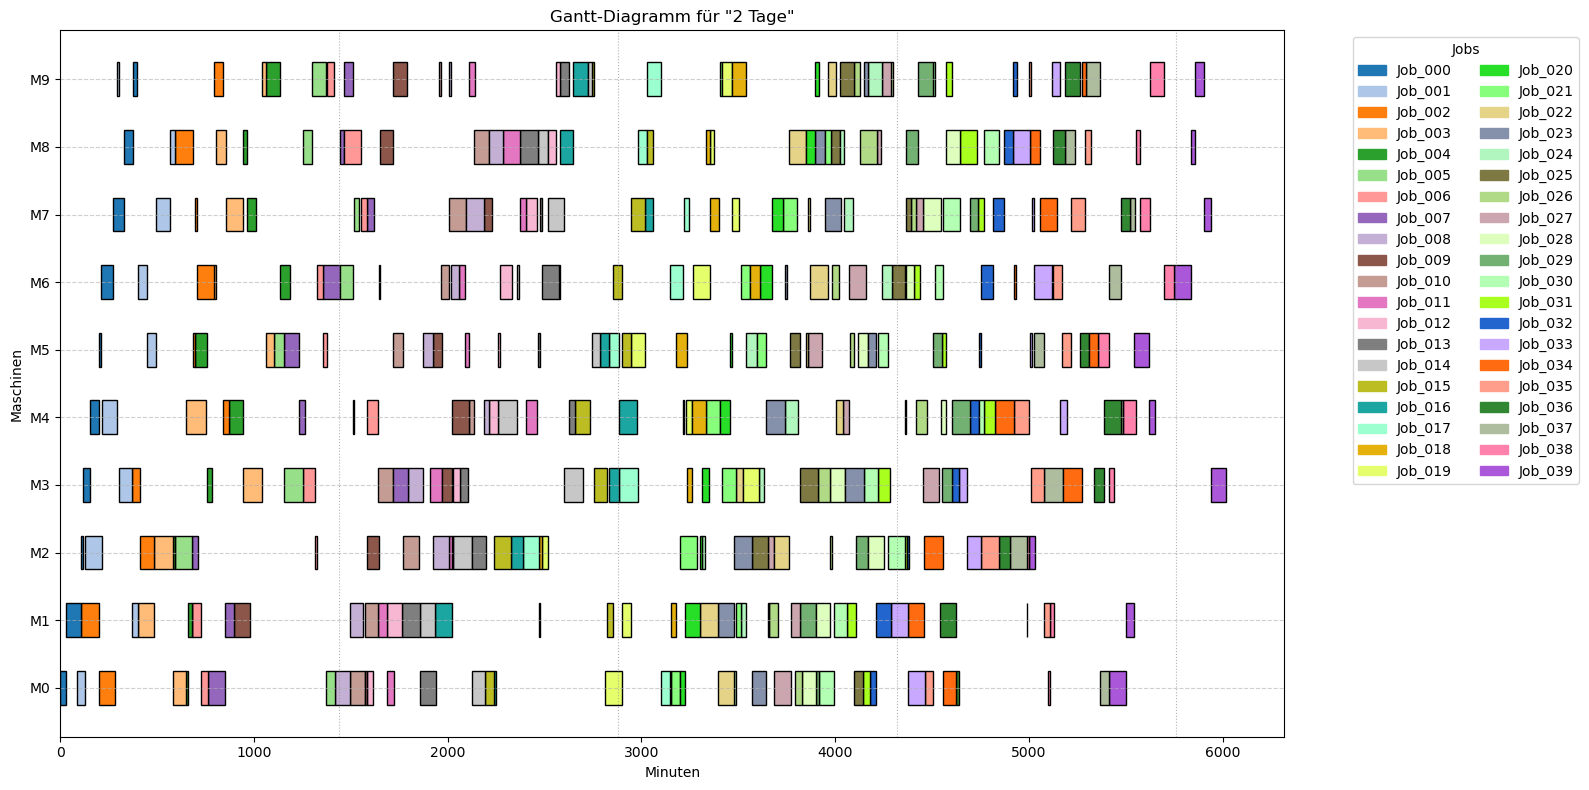

✅ Keine Maschinenkonflikte gefunden
✅ Job-Machinen-Reihenfolge (Reihenfolge der Operationen je Job) ist korrekt!
✅ Alle Operation starten erst nach Arrival des Job
✅ Zeitliche technologische Reihenfolge korrekt.

✅ Alle Constraints wurden erfüllt.



True

In [29]:
df = df_plan_max_tardiness
category = "2 Tage"
show.plot_gantt_jobs(df, 'Gantt-Diagramm für "{}"'.format(category), duration_column = "Processing Time")
show.plot_gantt_machines(df, 'Gantt-Diagramm für "{}"'.format(category), duration_column = "Processing Time")

check.check_all_constraints(df, jssp_data)

## Lateness 
- berücksichtigt auch eine negative Abweichung, also wenn ein Job früher fertiggestellt wurde als geplant.

$$
L_j = C_j - d_j
$$

**Legende:**

- $L_j$: Lateness (Verspätung oder Frühfertigung) des Jobs $j$  
- $C_j$: tatsächliche Fertigstellungszeit (Completion Time) von Job $j$  
- $d_j$: Deadline bzw. geplanter Fertigstellungstermin von Job $j$

**Interpretation:**

- $L_j > 0$: Job ist **verspätet**  
- $L_j = 0$: Job ist **pünktlich**  
- $L_j < 0$: Job ist **zu früh** fertig


### b) Absolute Lateness

$$
\min \; \max_{j \in J} \left| C_j - d_j \right|
$$

**Legende:**

- $J$: Menge aller Jobs  
- $C_j$: tatsächliche Endzeit (Completion Time) von Job $j$  
- $d_j$: Deadline von Job $j$  
- $\left| C_j - d_j \right|$: absolute Abweichung zur Deadline

**Erklärung:**  
Diese Zielfunktion behandelt **Früh- und Spätfertigung gleich** – sie versucht, die **größte Abweichung egal in welche Richtung** so gering wie möglich zu halten.


In [36]:
import pulp
import pandas as pd

def solve_jssp_max_absolute_lateness(job_dict, df_arrivals_deadlines, solver_time_limit=1200, epsilon=0.00):
    """
    Minimiert die maximale absolute Lateness (Früh- oder Spätfertigung) über alle Jobs.
    Zielfunktion: max_j [ |C_j - d_j| ]

    Parameter:
    - job_dict: Dictionary mit Jobdaten (jede Operation als (Maschine, Dauer))
    - df_arrivals_deadlines: DataFrame mit Spalten "Job", "Arrival", "Deadline"
    - solver_time_limit: Max. Zeit in Sekunden für den Solver
    - epsilon: Kleiner Abstand zur Vermeidung von Maschinenkonflikten
    """

    df_arrivals_deadlines = df_arrivals_deadlines.sort_values("Arrival").reset_index(drop=True)
    arrival_times = df_arrivals_deadlines.set_index("Job")["Arrival"].to_dict()
    deadlines = df_arrivals_deadlines.set_index("Job")["Deadline"].to_dict()

    job_names = list(df_arrivals_deadlines.sort_values("Arrival", ascending=False)["Job"])

    num_jobs = len(job_names)
    all_ops = [job_dict[job] for job in job_names]
    all_machines = {op[0] for job in all_ops for op in job}

    prob = pulp.LpProblem("JobShop_Max_Absolute_Lateness", pulp.LpMinimize)

    starts = {
        (j, o): pulp.LpVariable(f"start_{j}_{o}", lowBound=0, cat="Continuous")
        for j in range(num_jobs) for o in range(len(all_ops[j]))
    }

    job_ends = {
        j: pulp.LpVariable(f"job_end_{j}", lowBound=0, cat="Continuous")
        for j in range(num_jobs)
    }

    abs_lateness = {
        j: pulp.LpVariable(f"abs_lateness_{j}", lowBound=0, cat="Continuous")
        for j in range(num_jobs)
    }

    max_abs_lateness = pulp.LpVariable("max_abs_lateness", lowBound=0, cat="Continuous")

    prob += max_abs_lateness

    for j, job_name in enumerate(job_names):
        job = job_dict[job_name]
        prob += starts[(j, 0)] >= arrival_times[job_name]
        for o in range(1, len(job)):
            d_prev = job[o - 1][1]
            prob += starts[(j, o)] >= starts[(j, o - 1)] + d_prev

    bigM = 1e5
    for m in all_machines:
        ops = [(j, o, d) for j in range(num_jobs)
               for o, (mach, d) in enumerate(all_ops[j]) if mach == m]
        for i in range(len(ops)):
            j1, o1, d1 = ops[i]
            for j2, o2, d2 in ops[i + 1:]:
                if j1 != j2:
                    y = pulp.LpVariable(f"y_{j1}_{o1}_{j2}_{o2}", cat="Binary")
                    prob += starts[(j1, o1)] + d1 + epsilon <= starts[(j2, o2)] + bigM * (1 - y)
                    prob += starts[(j2, o2)] + d2 + epsilon <= starts[(j1, o1)] + bigM * y

    for j, job_name in enumerate(job_names):
        last_op = len(all_ops[j]) - 1
        prob += job_ends[j] == starts[(j, last_op)] + all_ops[j][last_op][1]

        lateness_expr = job_ends[j] - deadlines[job_name]
        prob += abs_lateness[j] >= lateness_expr
        prob += abs_lateness[j] >= -lateness_expr
        prob += max_abs_lateness >= abs_lateness[j]

    solver = pulp.HiGHS_CMD(msg=True, timeLimit=solver_time_limit)
    prob.solve(solver)

    schedule_data = []
    for (j, o), var in sorted(starts.items()):
        start = var.varValue
        if start is not None:
            machine, duration = all_ops[j][o]
            end = start + duration
            schedule_data.append({
                "Job": job_names[j],
                "Machine": f"M{machine}",
                "Start": round(start, 2),
                "Processing Time": duration,
                "End": round(end, 2)
            })

    df_schedule = pd.DataFrame(schedule_data)
    df_schedule["Arrival"] = df_schedule["Job"].map(arrival_times)
    df_schedule["Deadline"] = df_schedule["Job"].map(deadlines)
    df_schedule["Lateness"] = df_schedule.groupby("Job")["End"].transform("max") - df_schedule["Deadline"]
    df_schedule["Absolute Lateness"] = df_schedule["Lateness"].abs()

    df_schedule = df_schedule[["Job", "Arrival", "Deadline", "Machine", "Start", "Processing Time", "End", "Lateness", "Absolute Lateness"]]

    print("Maximale absolute Lateness:", round(pulp.value(max_abs_lateness), 3))
    return df_schedule

In [38]:
df_plan_max_absolute_lateness = solve_jssp_max_absolute_lateness(jssp_data, df_arrivals_deadlines, solver_time_limit=2700, epsilon=0.00)
df_plan_max_absolute_lateness

Maximale absolute Lateness: 279.429


,Job,Arrival,Deadline,Machine,Start,Processing Time,End,Lateness,Absolute Lateness
0,Job_039,2264.94,5676.442684,M2,4539.65,31,4570.65,279.427316,279.427316
1,Job_039,2264.94,5676.442684,M0,5441.42,86,5527.42,279.427316,279.427316
2,Job_039,2264.94,5676.442684,M1,5527.42,46,5573.42,279.427316,279.427316
3,Job_039,2264.94,5676.442684,M5,5573.42,74,5647.42,279.427316,279.427316
4,Job_039,2264.94,5676.442684,M4,5653.87,32,5685.87,279.427316,279.427316
...,...,...,...,...,...,...,...,...,...
395,Job_000,0.00,2500.080817,M5,201.00,11,212.00,-279.430817,279.430817
396,Job_000,0.00,2500.080817,M6,212.00,62,274.00,-279.430817,279.430817
397,Job_000,0.00,2500.080817,M7,274.00,56,330.00,-279.430817,279.430817
398,Job_000,0.00,2500.080817,M8,330.00,44,374.00,-279.430817,279.430817


In [ ]:
count_column_grouped(df_plan_max_absolute_lateness, 'Absolute Lateness')

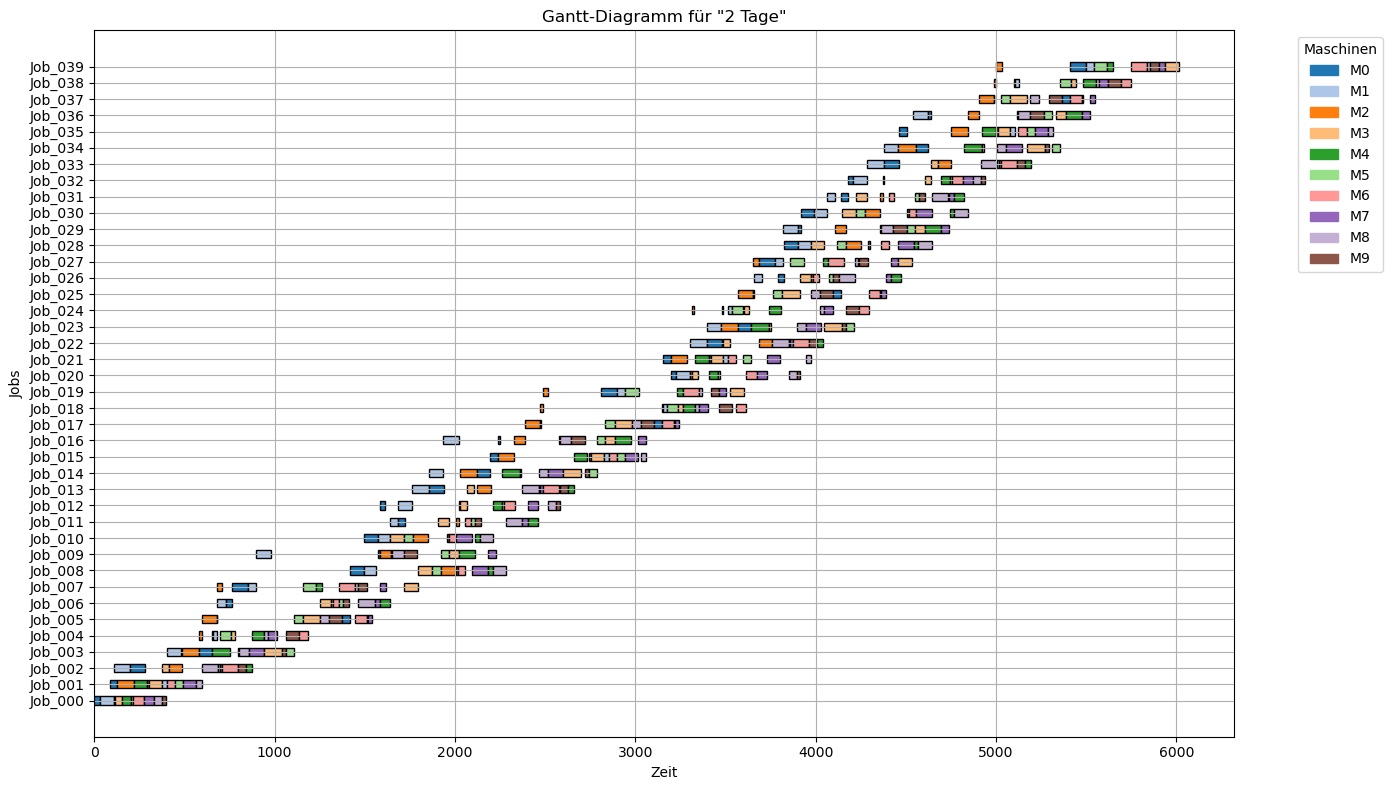

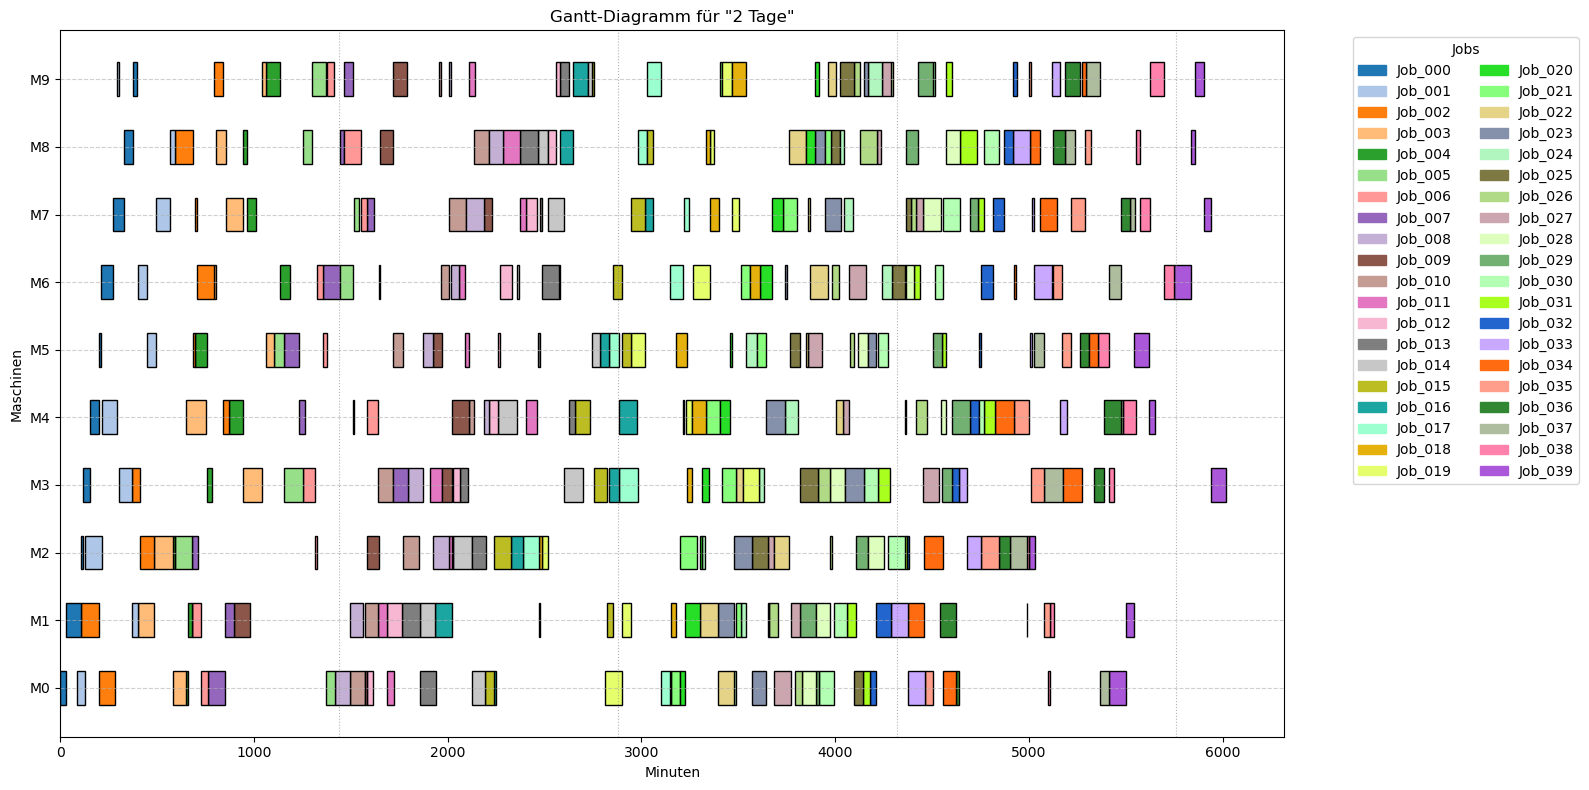

✅ Keine Maschinenkonflikte gefunden
✅ Job-Machinen-Reihenfolge (Reihenfolge der Operationen je Job) ist korrekt!
✅ Alle Operation starten erst nach Arrival des Job
✅ Zeitliche technologische Reihenfolge korrekt.

✅ Alle Constraints wurden erfüllt.



True

In [50]:
df = df_plan_max_absolute_lateness
category = "2 Tage"
show.plot_gantt_jobs(df, 'Gantt-Diagramm für "{}"'.format(category), duration_column = "Processing Time")
show.plot_gantt_machines(df, 'Gantt-Diagramm für "{}"'.format(category), duration_column = "Processing Time")

check.check_all_constraints(df, jssp_data)